# **IMPORTS**

In [1]:
%%time 

!pip install -q -r /kaggle/input/playgrounds4e12-public-imports-v1/req_kaggle.txt

exec(open('/kaggle/input/playgrounds4e12-public-imports-v1/myimports.py','r').read())
exec(open('/kaggle/input/playgrounds4e12-public-imports-v1/training.py','r').read())

%matplotlib inline
print()

---> XGBoost = 2.1.2 | LightGBM = 4.5.0 | Catboost = 1.2.7
---> Sklearn = 1.5.2| Pandas = 2.2.3
---> Imports- part 1 done

---> Commencing imports-part2
---> XGBoost = 2.1.2 | LightGBM = 4.5.0
---> Imports- part 2 done
---> Seeding everything

---> Imports done



CPU times: user 5.48 s, sys: 927 ms, total: 6.4 s
Wall time: 37.1 s


# **CONFIGURATION**

In [2]:
%%time 

class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;

    # Data preparation:-
    version_nb  = 1
    model_id    = "V1_4"
    model_label = "ML"

    test_req           = False
    test_sample_frac   = 0.01

    gpu_switch         = "OFF"
    state              = 42
    target             = f"PremiumAmount"
    grouper            = f""
    tgt_mapper         = {}

    ip_path            = f"/kaggle/input/playground-series-s4e12"
    op_path            = f"/kaggle/working"
    orig_path          = f"/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv"

    dtl_preproc_req    = True
    ftre_plots_req     = True
    ftre_imp_req       = True

    nb_orig            = 0
    orig_all_folds     = False

    # Model Training:-
    pstprcs_oof        = True
    pstprcs_train      = True
    pstprcs_test       = True
    
    ML                 = True
    test_preds_req     = False

    pseudo_lbl_req     = "N"
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00

    n_splits           = 3 if test_req == True else 5
    n_repeats          = 1
    nbrnd_erly_stp     = 0
    mdlcv_mthd         = 'SKF'

    # Ensemble:-
    ensemble_req       = True
    optuna_req         = False
    metric_obj         = 'minimize'
    ntrials            = 10 if test_req == True else 300

    # Global variables for plotting:-
    grid_specs = {'visible'  : True,
                  'which'    : 'both',
                  'linestyle': '--',
                  'color'    : 'lightgrey',
                  'linewidth': 0.75
                 }

    title_specs = {'fontsize'   : 9,
                   'fontweight' : 'bold',
                   'color'      : '#992600',
                  }

PrintColor(f"\n---> Configuration done!\n")

cv_selector = \
{
 "RKF"   : RKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "RSKF"  : RSKF(n_splits = CFG.n_splits, n_repeats= CFG.n_repeats, random_state= CFG.state),
 "SKF"   : SKF(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "KF"    : KFold(n_splits = CFG.n_splits, shuffle = True, random_state= CFG.state),
 "GKF"   : GKF(n_splits = CFG.n_splits)
}

collect()


---> Configuration done!

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 180 ms


4

|Configuration parameter| Explanation| Data type| Sample values |  
| ---------------------- | ------------------------------- | --------------------- | --------------- |
| version_nb    | Version Number | int | 1 | 
| model_id      | Model ID    | string | V1_1 | 
| model_label   | Model Label | string | ML | 
| test_req      | Test Required| bool | True / False | 
| test_sample_frac| Test sampled fraction | int | 1000 |
| gpu_switch      | Do we need GPU support | bool | True / False |
| state           | Random state | int | 42 |
| target          | Target column | str |  |
| grouper         | CV grouper column | str |  |
| ip_path, op_path | Data paths  | str | |
| pstprcs_* | Do we need post-processing  | bool |True / False |
| ML| Do we need machine learning models  | bool |True / False |
| test_preds_req| Do we need test set predictions (training in inference kernel)  | bool |True / False |
| pseudo_lbl_req| Pseudo label required?  | bool |True / False |
| pseudo_lbl_* | Pseudo label cutoff | float | |
| n_splits/ n_repeats | N-splits and repeats for CV scheme | int | 3/5/10|
| nbrnd_erly_stp | Early stopping rounds | int | 40|
| mdlcv_mthd | Model CV method | str | RSKF|
| ensemble_req | Do we need ensemble | bool | True / False |
| optuna_req   | Do we need optuna | bool | True / False |
| metric_obj   | Metric direction | str | minimize/ maximize |
| ntrials      | Trials | int | 300 |

# **PREPROCESSING**

In [3]:
%%time 

exec(open('/kaggle/input/playgrounds4e12-public-imports-v1/pp.py','r').read())
pp = Preprocessor()
pp.DoPreprocessing();


Data shapes - train-test-original | (1200000, 20) (800000, 19) (278860, 20)

Train set head


,Age,Gender,AnnualIncome,MaritalStatus,NumberofDependents,EducationLevel,Occupation,HealthScore,Location,PolicyType,PreviousClaims,VehicleAge,CreditScore,InsuranceDuration,PolicyStartDate,CustomerFeedback,SmokingStatus,ExerciseFrequency,PropertyType,PremiumAmount
id,,,,,,,,,,,,,,,,,,,,
0,19.000,Female,10049.000,Married,1.000,Bachelor's,Self-Employed,22.599,Urban,Premium,2.000,17.000,372.000,5.000,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.000
1,39.000,Female,31678.000,Divorced,3.000,Master's,nan,15.570,Rural,Comprehensive,1.000,12.000,694.000,2.000,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.000
2,23.000,Male,25602.000,Divorced,3.000,High School,Self-Employed,47.178,Suburban,Premium,1.000,14.000,nan,3.000,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.000
3,21.000,Male,141855.000,Married,2.000,Bachelor's,nan,10.938,Rural,Basic,1.000,0.000,367.000,1.000,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.000
4,21.000,Male,39651.000,Single,1.000,Bachelor's,Self-Employed,20.376,Rural,Premium,0.000,8.000,598.000,4.000,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.000



Test set head


,Age,Gender,AnnualIncome,MaritalStatus,NumberofDependents,EducationLevel,Occupation,HealthScore,Location,PolicyType,PreviousClaims,VehicleAge,CreditScore,InsuranceDuration,PolicyStartDate,CustomerFeedback,SmokingStatus,ExerciseFrequency,PropertyType
id,,,,,,,,,,,,,,,,,,,
1200000,28.000,Female,2310.000,nan,4.000,Bachelor's,Self-Employed,7.658,Rural,Basic,nan,19.000,nan,1.000,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1200001,31.000,Female,126031.000,Married,2.000,Master's,Self-Employed,13.381,Suburban,Premium,nan,14.000,372.000,8.000,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
1200002,47.000,Female,17092.000,Divorced,0.000,PhD,Unemployed,24.355,Urban,Comprehensive,nan,16.000,819.000,9.000,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
1200003,28.000,Female,30424.000,Divorced,3.000,PhD,Self-Employed,5.136,Suburban,Comprehensive,1.000,3.000,770.000,5.000,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
1200004,24.000,Male,10863.000,Divorced,2.000,High School,Unemployed,11.844,Suburban,Premium,nan,14.000,755.000,7.000,2021-11-26 15:21:39.259788,Average,No,Weekly,House



Original set head


,Age,Gender,AnnualIncome,MaritalStatus,NumberofDependents,EducationLevel,Occupation,HealthScore,Location,PolicyType,PreviousClaims,VehicleAge,CreditScore,InsuranceDuration,PolicyStartDate,CustomerFeedback,SmokingStatus,ExerciseFrequency,PropertyType,PremiumAmount
id,,,,,,,,,,,,,,,,,,,,
0,56.000,Male,99990.000,Married,1.000,Master's,nan,31.075,Urban,Comprehensive,nan,13,320.000,5,2022-12-10 15:21:39.078837,Poor,Yes,Daily,Condo,308.000
1,46.000,Male,2867.000,Single,1.000,Bachelor's,nan,50.271,Urban,Comprehensive,nan,3,694.000,4,2023-01-31 15:21:39.078837,Good,Yes,Monthly,House,517.000
2,32.000,Female,30154.000,Divorced,3.000,Bachelor's,nan,14.715,Suburban,Comprehensive,2.000,16,652.000,8,2023-11-26 15:21:39.078837,Poor,No,Monthly,House,849.000
3,60.000,Female,48371.000,Divorced,0.000,PhD,Self-Employed,25.347,Rural,Comprehensive,1.000,11,330.000,7,2023-02-27 15:21:39.078837,Poor,No,Rarely,Condo,927.000
4,25.000,Female,54174.000,Divorced,0.000,High School,Self-Employed,6.659,Urban,Comprehensive,nan,9,nan,8,2020-11-25 15:21:39.078837,Poor,No,Rarely,Condo,303.000



We are using the competition training data only
CPU times: user 7.27 s, sys: 2.17 s, total: 9.44 s
Wall time: 12 s


# **DATA TRANSFORMS**

In [4]:
%%time 

class FeatureMaker:
    "This class develops features as per the requirement and cleans up the dataset off outliers"

    def __init__(self):
        self.target = CFG.target

    def fit(self, X, y = None, **fit_params):
        return self

    def transform(
        self, 
        X        : pd.DataFrame, y = None,  
        cat_cols : list = [],
        mode     : str  = "Train",
        **params
    ):
        "This method transforms the dataset based on additional columns and data cleaning"

        df = X.copy()

        df["PolicyStartDate"] = pd.to_datetime(df["PolicyStartDate"])
        
        df["Month"]   = df["PolicyStartDate"].dt.month
        df["Day"]     = df["PolicyStartDate"].dt.day
        df["Week"]    = df["PolicyStartDate"].dt.isocalendar().week
        df["Weekday"] = df["PolicyStartDate"].dt.weekday
        df['DaySin']  = np.sin(2 * np.pi * df['Day'] / 30)  
        df['DayCos']  = np.cos(2 * np.pi * df['Day'] / 30)
        
        df['DaysSinceStart']  = \
        np.ceil(
            (pd.to_datetime("12-31-2024") - df["PolicyStartDate"])/ pd.Timedelta(1, "d")
        )
        
        df["Ratio_IncomeAge"]   = np.clip(df["AnnualIncome"] / df["Age"], a_min = 1e-6, a_max = 1e9)
        df["Score"]             = df["CreditScore"] + df["HealthScore"]
        
        df = df.drop("PolicyStartDate", axis=1, errors = "ignore")
        
        if mode == "Train" :
            cat_cols = \
            (df.
             drop(["Source", "PolicyStartDate"], axis=1, errors = "ignore").
             select_dtypes(["object", pd.StringDtype, "category"]).
             columns
            )

        for col in cat_cols:
            try:
                df[col] = \
                df[col].astype(pd.StringDtype).fillna("missing").astype("category")
            except:
                df[col] = df[col].fillna("missing").astype("category")
        
        return (df, list(cat_cols))

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 31 µs


In [5]:
%%time 

Xtrain = pp.train.copy()

if CFG.test_req:
    Xtrain = Xtrain.groupby(["Source", CFG.target], as_index = False).sample(frac = CFG.test_sample_frac)
    Xtrain.index = range(len(Xtrain))
    PrintColor(f"---> Syntax check mode - shape = {Xtrain.shape}", color = Fore.RED)
    
ytrain = Xtrain[CFG.target]
Xtrain = Xtrain.drop([CFG.target, CFG.grouper], axis= 1, errors = "ignore")  

xform = FeatureMaker()
xform.fit(Xtrain, ytrain);

Xtrain, cat_cols  = xform.transform(Xtrain, cat_cols = [], mode = "Train")
Xtest, _          = xform.transform(pp.test, cat_cols = cat_cols, mode = "Test")

PrintColor(f"\n---> Shapes = {Xtrain.shape} {ytrain.shape} {Xtest.shape}")

# Initializing the cv scheme:-
cv = cv_selector[CFG.mdlcv_mthd]

if CFG.nb_orig > 0:
    all_df = []
    
    for mysource in ["Competition", "Original"]:
        df = pd.concat([Xtrain.loc[Xtrain.Source == mysource], ytrain], axis=1, join = "inner")
        df.index = range(len(df))
        for fold_nb, (_, dev_idx) in enumerate(cv.split(df, df[CFG.target])):
            df.loc[dev_idx, "fold_nb"] = fold_nb
            
        all_df.append(df)      
    ygrp = pd.concat(all_df, axis=0, ignore_index = True)["fold_nb"].astype(np.uint8)
                      
else:
    df = Xtrain.loc[Xtrain.Source == "Competition"]
    df.index = range(len(df))
    
    for fold_nb, (_, dev_idx) in enumerate(cv.split(df, ytrain.iloc[df.index])):
        df.loc[dev_idx, "fold_nb"] = fold_nb 
    ygrp = df["fold_nb"].astype(np.uint8)

ytrain = np.log1p(ytrain)

collect();
print();

_ = utils.CleanMemory()


---> Shapes = (1200000, 28) (1200000,) (800000, 28)

CPU times: user 8.63 s, sys: 1.05 s, total: 9.68 s
Wall time: 9.69 s


# **MODEL TRAINING**

In [ ]:
%%time 

try:
    l = MyLogger()
    l.init(logging_lbl = "lightgbm_custom")
    lgb.register_logger(l)
except:
    pass

def mymetric(ytrue, ypred):
    """
    Custom evaluation metric to track RMSLE during training.
    
    Args:
        ytrue - true values
        ypred - prediction values
    """
    return ('RMSLE', utils.ScoreMetric(ytrue, np.clip(ypred, 20, 4999)), False)
    
Mdl_Master = {   
    f'CB1R': CBR(**{
        "loss_function": "RMSE",
        'task_type': "GPU" if CFG.gpu_switch == "ON" else "CPU",
        'learning_rate': 0.02,  
        'iterations': 300,  
        'max_bin': 16384,
        'max_depth': 10,  
        'colsample_bylevel': 0.75,  
        'l2_leaf_reg': 0.5,  
        'random_strength': 0.3,  
        'verbose': 0,
        'random_state': CFG.state,
        'cat_features': cat_cols,
    }),

    f'LGBM1R': LGBMR(**{
        "objective": "regression_l2",
        'device': "gpu" if CFG.gpu_switch == "ON" else "cpu",
        'metric': "custom",
        'learning_rate': 0.025,  
        'n_estimators': 300,  
        'max_bin': 8192,
        'max_depth': 10,  
        'num_leaves': 150, 
        'min_data_in_leaf': 100, 
        'colsample_bytree': 0.8,  
        'lambda_l1': 0.01,
        'lambda_l2': 0.02, 
        'verbosity': -1,
        'random_state': CFG.state,
    }),

    f'LGBM2R': LGBMR(**{
        "objective": "regression_l2",
        'device': "gpu" if CFG.gpu_switch == "ON" else "cpu",
        'metric': "custom",
        'data_sample_strategy': 'goss',
        'learning_rate': 0.03,  
        'n_estimators': 200,  
        'max_bin': 4096,
        'max_depth': 10, 
        'num_leaves': 80,  
        'min_data_in_leaf': 100,  
        'colsample_bytree': 0.8,  
        'lambda_l1': 0.01,
        'lambda_l2': 0.02, 
        'verbosity': -1,
        'random_state': CFG.state,
    }),

    f'XGB1R': XGBR(**{
        "objective": "reg:squarederror",
        'device': "cuda" if CFG.gpu_switch == "ON" else "cpu",
        'disable_default_eval_metric': True,
        'learning_rate': 0.02, 
        'n_estimators': 300,  
        'max_bin': 8192,
        'max_depth': 10, 
        'colsample_bytree': 0.8,  
        'colsample_bylevel': 0.75,
        'lambda_l1': 0.01,
        'lambda_l2': 0.02,  
        'verbose': 0,
        'random_state': CFG.state,
        'enable_categorical': True,
    }),
}


# Initializing model outputs
OOF_Preds    = {}
Mdl_Preds    = {}
FittedModels = {}
FtreImp      = {}
SelMdlCols   = {}

CPU times: user 0 ns, sys: 676 µs, total: 676 µs
Wall time: 2.81 ms


  0%|          | 0/4 [00:00<?, ?it/s]


==================== CB1R MODEL TRAINING ====================

Selected columns = 28


0it [00:00, ?it/s]


---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
CB1R Fold0           OOF = 1.046014 | Train = 1.044688 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
CB1R Fold1           OOF = 1.048123 | Train = 1.043952 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
CB1R Fold2           OOF = 1.047188 | Train = 1.044214 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
CB1R Fold3           OOF = 1.045890 | Train = 1.044743 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
CB1R Fold4           OOF = 1.047123 | Train = 1.044207 




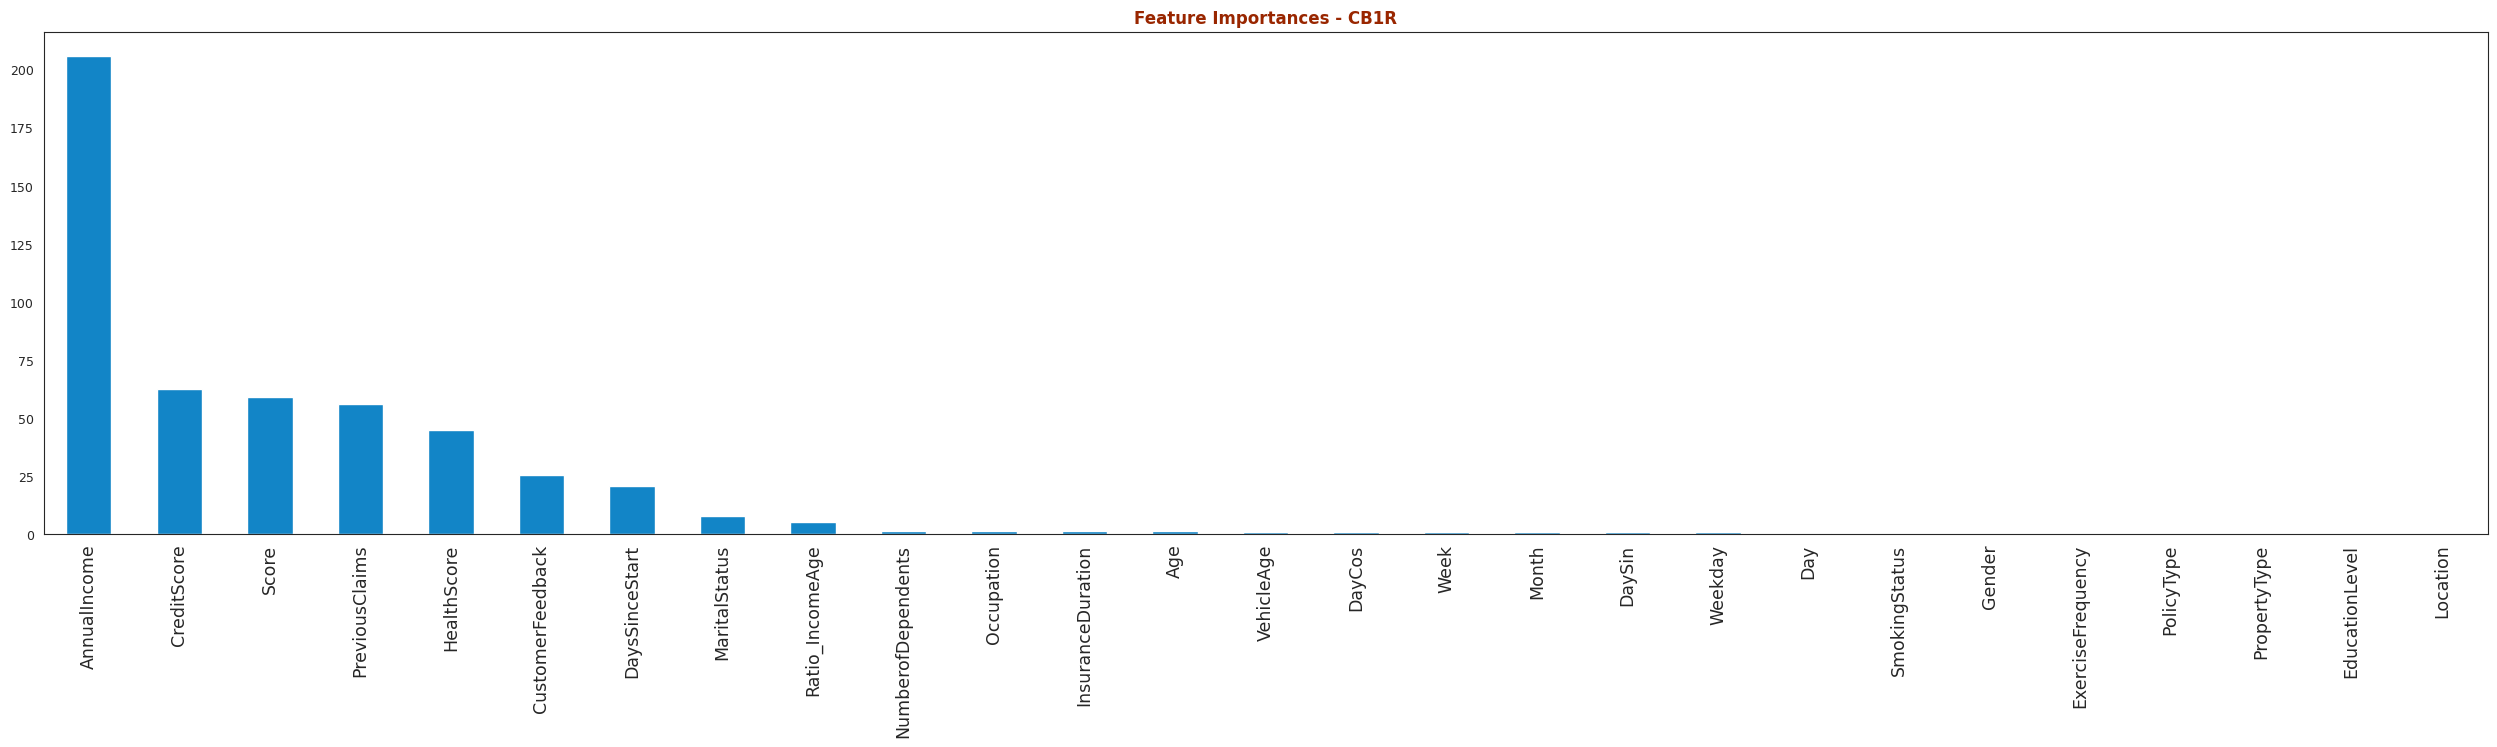



---> 1.046868 +- 0.000828 | OOF
---> 1.044361 +- 0.000305 | Train


==================== LGBM1R MODEL TRAINING ====================

Selected columns = 28


0it [00:00, ?it/s]


---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM1R Fold0         OOF = 1.044413 | Train = 1.033913 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM1R Fold1         OOF = 1.046700 | Train = 1.033234 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM1R Fold2         OOF = 1.045065 | Train = 1.033653 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM1R Fold3         OOF = 1.043887 | Train = 1.034038 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM1R Fold4         OOF = 1.045452 | Train = 1.033592 




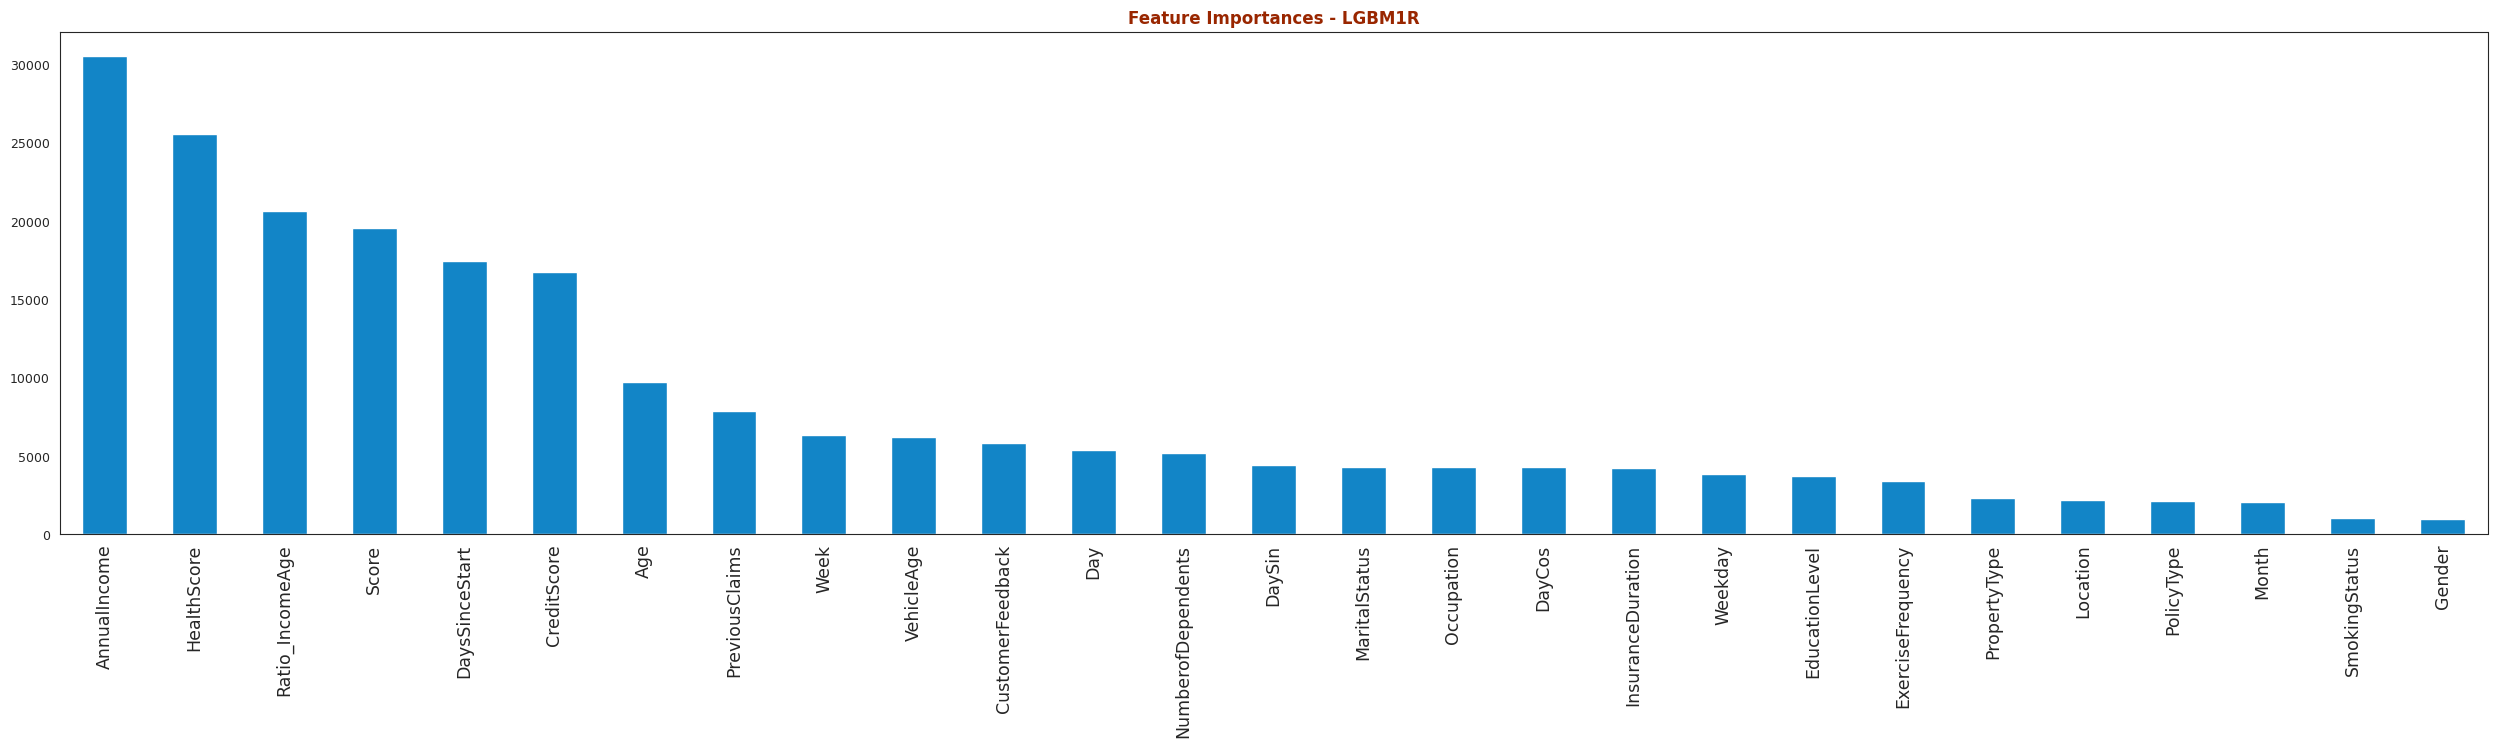



---> 1.045104 +- 0.000962 | OOF
---> 1.033686 +- 0.000279 | Train


==================== LGBM2R MODEL TRAINING ====================

Selected columns = 28


0it [00:00, ?it/s]


---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM2R Fold0         OOF = 1.044804 | Train = 1.040606 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM2R Fold1         OOF = 1.046982 | Train = 1.039889 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM2R Fold2         OOF = 1.045469 | Train = 1.040413 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM2R Fold3         OOF = 1.044259 | Train = 1.040753 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
LGBM2R Fold4         OOF = 1.045940 | Train = 1.040234 




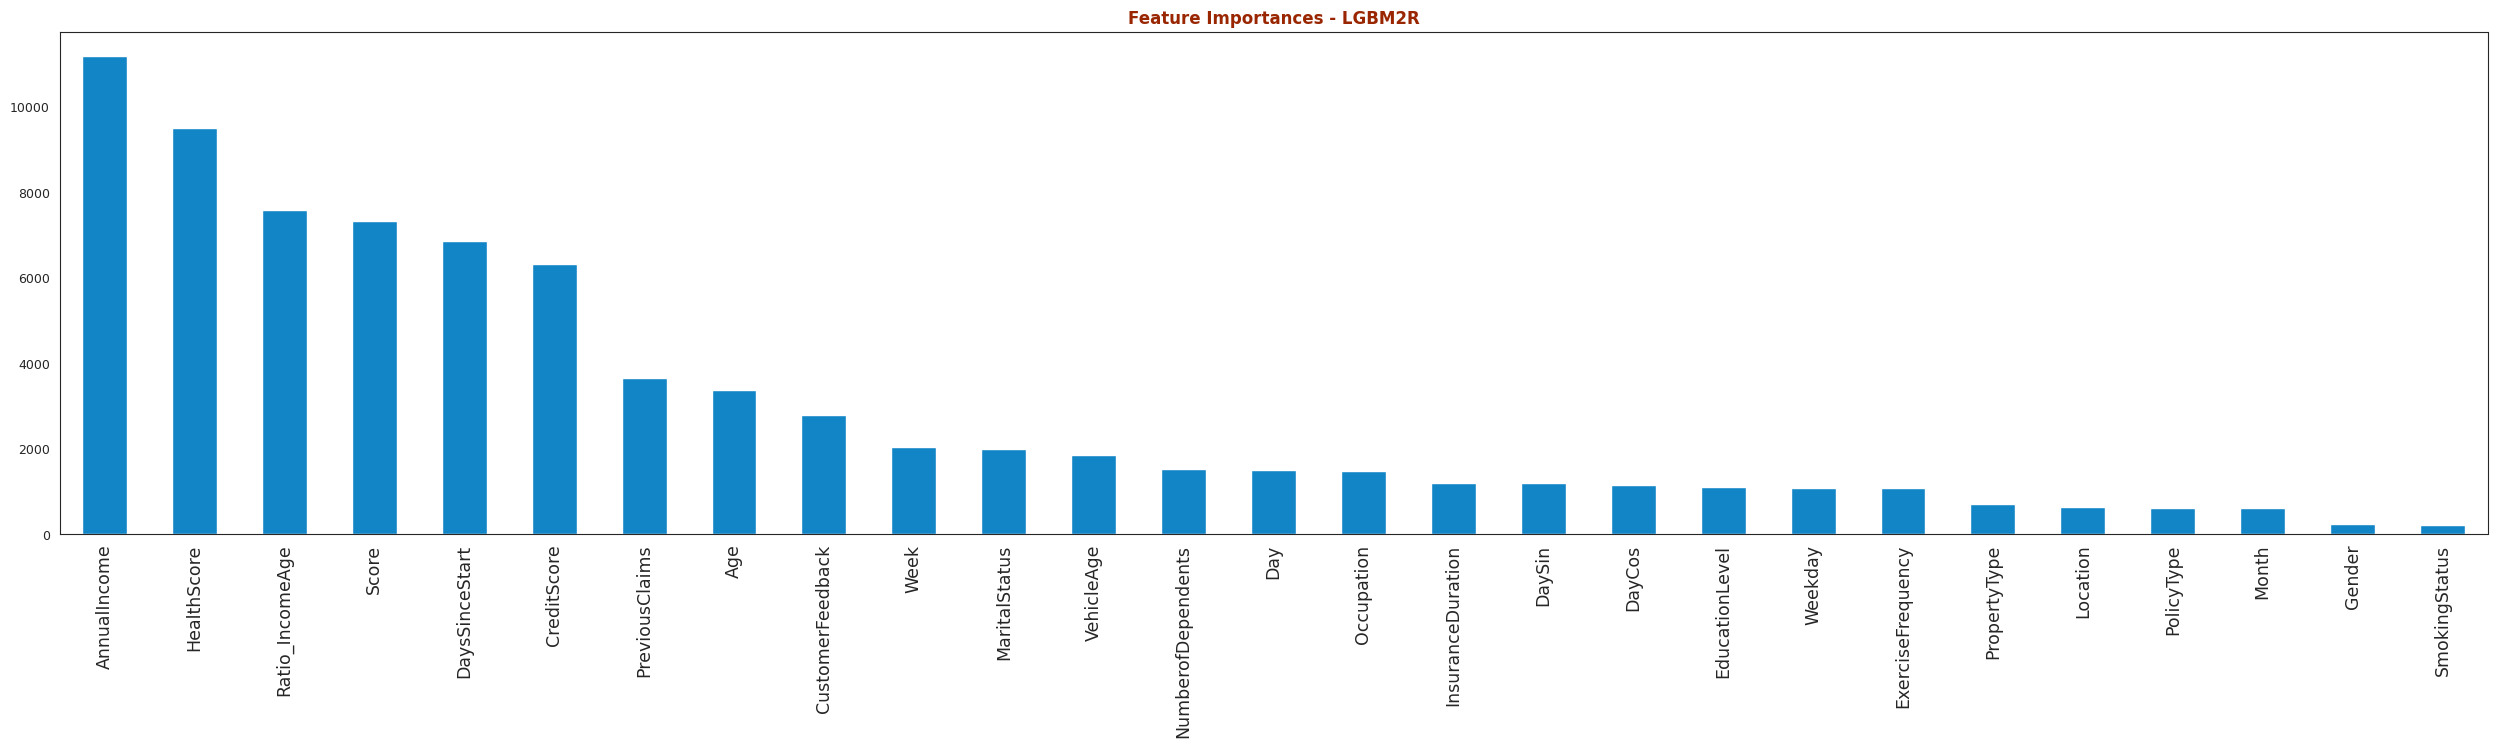



---> 1.045491 +- 0.000940 | OOF
---> 1.040379 +- 0.000301 | Train


==================== XGB1R MODEL TRAINING ====================

Selected columns = 28


0it [00:00, ?it/s]


---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
XGB1R Fold0          OOF = 1.044483 | Train = 1.013698 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
XGB1R Fold1          OOF = 1.046852 | Train = 1.011124 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
XGB1R Fold2          OOF = 1.045298 | Train = 1.013359 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
XGB1R Fold3          OOF = 1.043955 | Train = 1.013743 

---> Shapes = (960000, 27) (960000,) -- (240000, 27) (240000,) -- (800000, 27)
XGB1R Fold4          OOF = 1.045689 | Train = 1.013210 




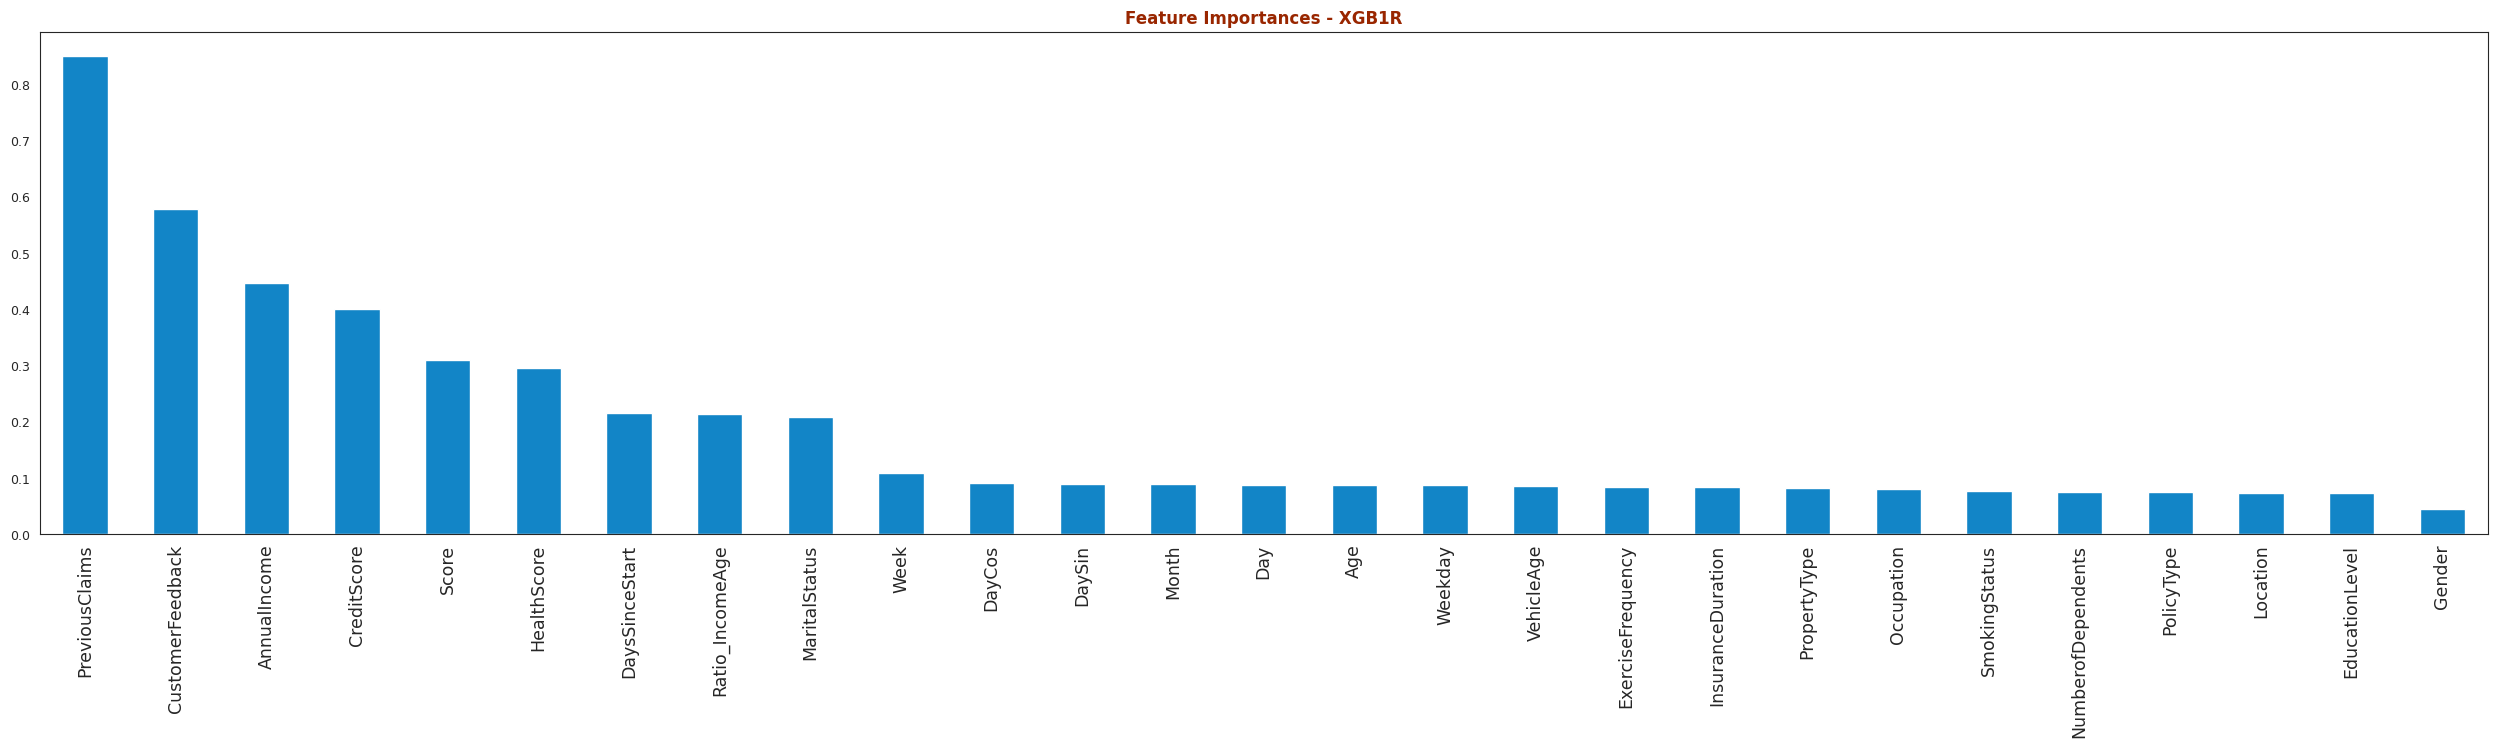



---> 1.045255 +- 0.001003 | OOF
---> 1.013027 +- 0.000973 | Train

CPU times: user 3h 59s, sys: 29min 36s, total: 3h 30min 35s
Wall time: 1h 11min 42s


In [7]:
%%time

# Model training:-
drop_cols = ["Source", "id", "Id", "Label", CFG.target, "fold_nb"]

for method, mymodel in tqdm(Mdl_Master.items()):

    PrintColor(f"\n{'=' * 20} {method.upper()} MODEL TRAINING {'=' * 20}\n")

    md = \
    ModelTrainer(
        problem_type   = "regression",
        es             = CFG.nbrnd_erly_stp,
        target         = CFG.target,
        orig_req       = True if CFG.nb_orig > 0 else False,
        orig_all_folds = CFG.orig_all_folds,
        metric_lbl     = "rmsle",
        drop_cols      = drop_cols,
        pp_preds       = CFG.pstprcs_oof,
        )

    sel_mdl_cols = list(Xtest.columns) 
    PrintColor(
        f"Selected columns = {len(sel_mdl_cols) :,.0f}", 
        color = Fore.RED
    )
    SelMdlCols[method] = (sel_mdl_cols, cat_cols)

    Xtrain_ = Xtrain.copy()
    Xtest_  = Xtest.copy()

    if "CB" in method :
        Xtrain_[cat_cols] = Xtrain_[cat_cols].astype(pd.StringDtype)
        Xtest_[cat_cols]  = Xtest_[cat_cols].astype(pd.StringDtype)
    else:
        pass

    fitted_models, oof_preds, test_preds, ftreimp, mdl_best_iter =  \
    md.MakeOfflineModel(
        Xtrain_,
        ytrain,
        ygrp,
        Xtest_,
        clone(mymodel),
        method,
        test_preds_req   = True,
        ftreimp_plot_req = CFG.ftre_imp_req,
        ntop = 50,
    )

    OOF_Preds[method]    = oof_preds
    Mdl_Preds[method]    = test_preds
    FittedModels[method] = fitted_models
    FtreImp[method]      = ftreimp

    del fitted_models, oof_preds, test_preds, ftreimp, sel_mdl_cols, Xtrain_, Xtest_
    print()
    collect();

_ = utils.CleanMemory();


# **ENSEMBLE**

In [8]:
%%time 

oof_preds = pd.DataFrame(OOF_Preds)
mdl_preds = pd.DataFrame(Mdl_Preds)

oof_ens_preds = oof_preds.mean(axis=1).values
test_preds    = mdl_preds.mean(axis=1).values

score = \
utils.ScoreMetric(
    md.PostProcessPreds(ytrain.values), 
    oof_ens_preds
)

PrintColor(f"\n---> Final Ensemble Score = {score :,.6f}\n\n")


---> Final Ensemble Score = 1.045241


CPU times: user 230 ms, sys: 40.1 ms, total: 270 ms
Wall time: 269 ms


# **CLOSURE**

In [9]:
%%time 

try:
    oof_preds.assign(**{"Ensemble": oof_ens_preds}).\
    to_parquet(
        os.path.join(CFG.op_path, f"OOF_Preds_{CFG.model_label}{CFG.model_id}.parquet")
    )

    mdl_preds.assign(**{"Ensemble": test_preds}).\
    to_parquet(
        os.path.join(CFG.op_path, f"Mdl_Preds_{CFG.model_label}{CFG.model_id}.parquet")
    )
    
except:
    oof_preds.\
    to_parquet(
        os.path.join(CFG.op_path, f"OOF_Preds_{CFG.model_label}{CFG.model_id}.parquet")
    )  
    
    mdl_preds.\
    to_parquet(
        os.path.join(CFG.op_path, f"Mdl_Preds_{CFG.model_label}{CFG.model_id}.parquet")
    )

pp.sub_fl[f"Premium Amount"] = test_preds
pp.sub_fl.to_csv(
    os.path.join(CFG.op_path, f"submission.csv"), index = None
)


print()
!ls
print()
!head submission.csv

_ = utils.CleanMemory()
print()


Mdl_Preds_MLV1_4.parquet  __notebook__.ipynb  submission.csv
OOF_Preds_MLV1_4.parquet  catboost_info       xgb_optimize.log

id,Premium Amount
1200000,800.7458995716811
1200001,790.7416029921781
1200002,795.1071703767469
1200003,795.2082342255579
1200004,757.075965426373
1200005,776.5530905399705
1200006,953.6985489047788
1200007,733.4337916376135
1200008,199.15549894189377

CPU times: user 1.9 s, sys: 531 ms, total: 2.43 s
Wall time: 4.56 s
